In [1]:
import pennylane as qml
import pennylane.numpy as np
import jax.numpy as jnp

import jax
import optax

from tqdm.notebook import tqdm
import math

from time import time
import pickle

import matplotlib.pyplot as plt

import os, sys, argparse

parent = os.path.abspath('../src/')
sys.path.insert(1, parent)

from perceptron import Perceptron



# Set to float64 precision and remove jax CPU/GPU warning
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")


In [2]:
perceptron_qubits = 2

dev = qml.device("default.qubit.jax", wires = perceptron_qubits)

# transverse_field_coefficient = args.field
pulse_basis = 3+5


t0 = 0.0
tf = 1.0
# n_steps = 50


I0000 00:00:1697123366.571715       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [30]:
perceptron = Perceptron(perceptron_qubits, pulse_basis, basis='gaussian', pulse_width=0.1)

H =  perceptron.H


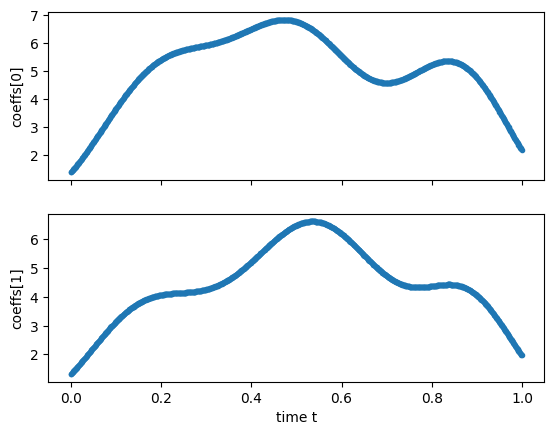

In [31]:

random_seed = 10293

param_vector = perceptron.get_random_parameter_vector(random_seed)


ts = jnp.linspace(0.0, 1, 1000)[:-1]

param_list = perceptron.vector_to_hamiltonian_parameters(param_vector)

fig, axs = plt.subplots(nrows=perceptron_qubits, sharex=True)
for i in range(perceptron_qubits):
    ax = axs[i]
    ax.plot(ts, perceptron.control_fields[i](param_list[i+perceptron_qubits-1], ts), ".-")
    ax.set_ylabel(f"coeffs[{i}]")
ax.set_xlabel("time t")
plt.show()

In [5]:
def generate_random_parameter_lists(perceptron, keys):

    parameters_for_unitaries = []

    for k in keys:

        param_vector = perceptron.get_random_parameter_vector(k)
        param_list = perceptron.vector_to_hamiltonian_parameters(param_vector)

        parameters_for_unitaries.append(param_list)
    return parameters_for_unitaries

seed = 0
key = jax.random.PRNGKey(seed)

random_numbers = jax.random.randint(key, shape=(100,), minval=0, maxval=19190)  # maxval is exclusive


In [6]:
def generate_Us(thetas, H):

    list_of_Us = []

    for list in thetas:

        list_of_Us.append(qml.matrix(qml.evolve(H)(list, [t0, tf])))
    
    return list_of_Us


def generate_Vs(thetas, H):

    list_of_Vs = []

    for list in thetas:

        list_of_Vs.append(qml.matrix(qml.adjoint(qml.evolve(H)(list, [t0, tf]))))
    
    return list_of_Vs


def F(k, Us, Vs):

    sum = 0

    for jj in range(len(Us)):
        
        sum += jnp.abs(jnp.trace(Us[jj].dot(Vs[jj])))**(2*k)
        

    return sum/(50**2)

# Perceptron with $0.01$ pulse width

In [9]:
X = [i+1 for i in range(10)]
potentials = {}


for num_pulses in [2,5,7,9,12]:


    perceptron = Perceptron(perceptron_qubits, num_pulses, basis='gaussian', pulse_width=0.01)

    H = perceptron.H

    parameters_for_unitaries = generate_random_parameter_lists(perceptron, random_numbers)
    
    Us = generate_Us(parameters_for_unitaries[:50], H)
    Vs = generate_Vs(parameters_for_unitaries[50:], H)

    potential = [F(x, Us, Vs) for x in X]

    potentials[f'{num_pulses}'] = potential


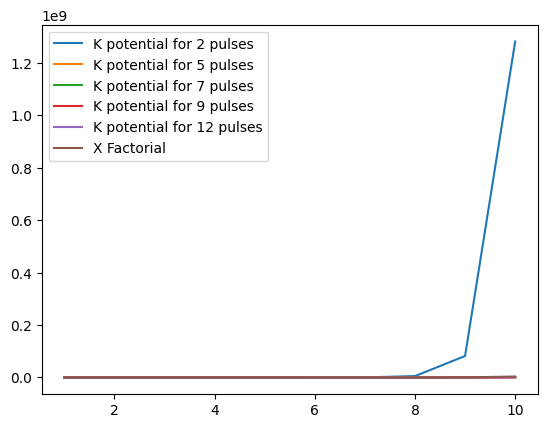

In [10]:
for key, value in potentials.items():

    plt.plot(X, value, label = 'K potential for ' + key + ' pulses')


XFactorial = [math.factorial(x) for x in X]

plt.plot(X,XFactorial, label = 'X Factorial')

plt.legend()

plt.show()

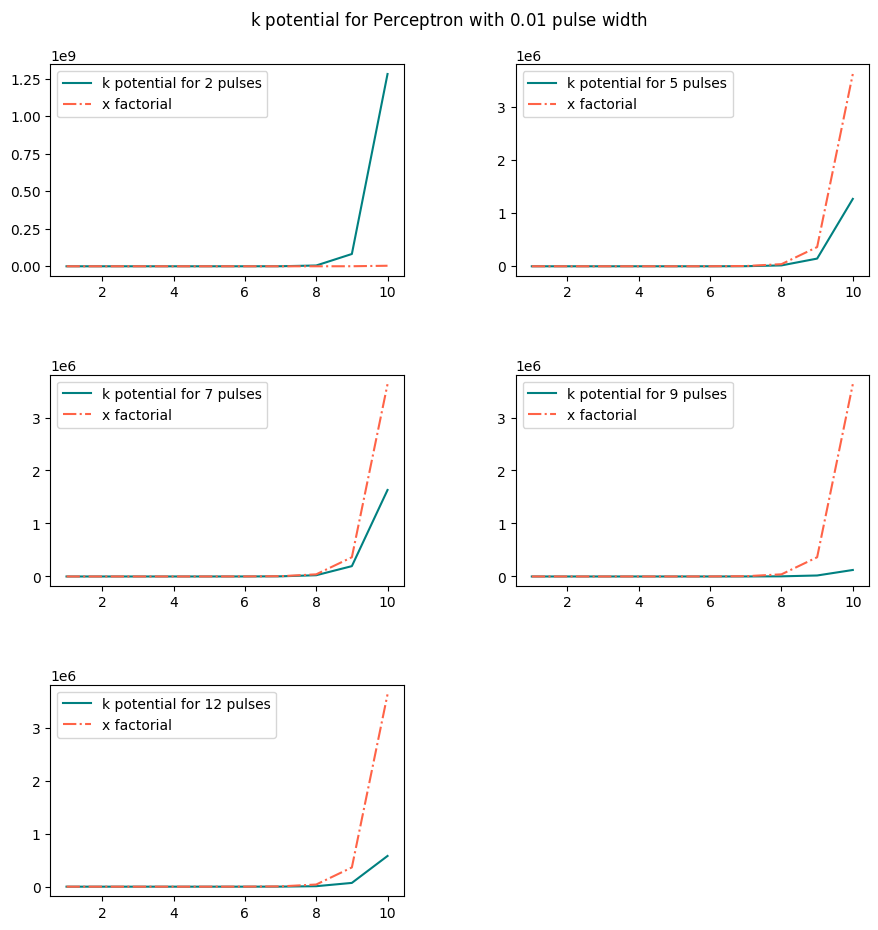

In [29]:
# Determine the number of rows and columns for the mosaic
num_plots = len(potentials)
cols = 2  # for instance, we want 2 columns
rows = num_plots // cols + (num_plots % cols > 0)


XFactorial = [math.factorial(x) for x in X]

# Create a figure and set of subplots
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
fig.tight_layout(pad=5.0)

# Iterate through the dictionary and plot
for ax, (key, value) in zip(axes.ravel(), potentials.items()):

    ax.plot(X, value, label = 'k potential for ' + key + ' pulses', color='teal')
    ax.plot(X, XFactorial, label = 'x factorial',linestyle = "-.", color='tomato')
    ax.legend()


# Hide any remaining empty subplots
for ax in axes.ravel()[num_plots:]:
    ax.axis('off')


fig.suptitle(f'k potential for Perceptron with $0.01$ pulse width')

plt.show()




# Perceptron with $0.1$ pulse width

In [32]:
X = [i+1 for i in range(10)]
potentials = {}


for num_pulses in [2,5,7,9,12]:


    perceptron = Perceptron(perceptron_qubits, num_pulses, basis='gaussian', pulse_width=0.1)

    H = perceptron.H

    parameters_for_unitaries = generate_random_parameter_lists(perceptron, random_numbers)
    
    Us = generate_Us(parameters_for_unitaries[:50], H)
    Vs = generate_Vs(parameters_for_unitaries[50:], H)

    potential = [F(x, Us, Vs) for x in X]

    potentials[f'{num_pulses}'] = potential

2023-10-12 12:01:12.783257: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 4m18.879364s

********************************
[Compiling module jit__odeint_wrapper] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-10-12 12:30:23.960207: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 17m34.508088s

********************************
[Compiling module jit__odeint_wrapper] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


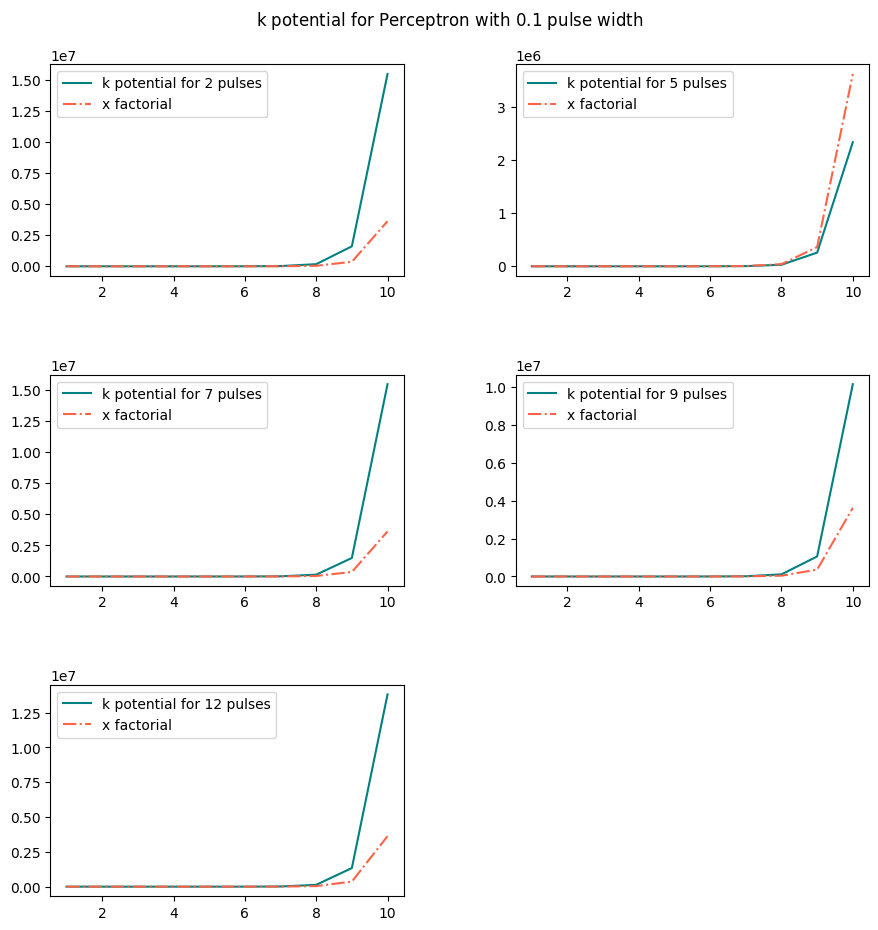

In [34]:
# Determine the number of rows and columns for the mosaic
num_plots = len(potentials)
cols = 2  # for instance, we want 2 columns
rows = num_plots // cols + (num_plots % cols > 0)


XFactorial = [math.factorial(x) for x in X]

# Create a figure and set of subplots
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
fig.tight_layout(pad=5.0)

# Iterate through the dictionary and plot
for ax, (key, value) in zip(axes.ravel(), potentials.items()):

    ax.plot(X, value, label = 'k potential for ' + key + ' pulses', color='teal')
    ax.plot(X, XFactorial, label = 'x factorial',linestyle = "-.", color='tomato')
    ax.legend()


# Hide any remaining empty subplots
for ax in axes.ravel()[num_plots:]:
    ax.axis('off')


fig.suptitle(f'k potential for Perceptron with $0.1$ pulse width')

plt.show()